# Classification of events using TMVA : Boosted Decision Trees

In this example, we use the [Toolkit for Multivariate Data Analysis with ROOT (TMVA)](http://root.cern/tmva) to classify events from particle collisions to determine whether they contain Higgs bosons.

In this tutorial we'll learn how to tell TMVA to process data and we'll train a Boosted Decision Tree (BDT).

There are many resources available online regarding TMVA, including it's [User's Guide](https://root.cern/download/doc/tmva/TMVAUsersGuide.pdf).


In [1]:
# Importing the ROOT module
import ROOT
# Importing the TMVA, TFile (to open ROOT files) and TCut (to filter data)
from ROOT import TMVA, TFile, TCut

# Initialising TMVA
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize();

Welcome to JupyROOT 6.18/04


## Creating the TMVA Factory

We now need to create a *Factory*, which will handle our interaction with TMVA and save the various inputs and outputs to the specified file (here `TMVA-Classification-Higgs-BDT.root`). 

We'll set up the factory to perform a *classification analysis* to discriminate the *signal* events against the *background* events.

We've configured the factory to test several transformations:
- I: identity
- D: decorrelation
- P: PCA
- U: uniform
- G: Gaussian


Note: there is a more Pythonic version, but there were some issues running this with the latest ROOT version.

```
%jsmva
outputFile = "TMVA-Classification-Higgs.root"
factory = TMVA.Factory("TMVAClassification", TargetFile=outputFile,
                       V=False, Color=True, DrawProgressBar=True, 
                       Transformations=["I", "D", "P", "G", "D"],
                       AnalysisType="Classification")
```

In [2]:
# This will overwrite the file at each execution
outputFile = TFile( "TMVA-Classification-Higgs-BDT.root", "RECREATE" ) 
factory = TMVA.Factory( "TMVAClassification", outputFile,
                        "!V:Color:DrawProgressBar:Transformations=I;D;P;G,D:AnalysisType=Classification" )

## Reading in the data

We need to import our data to run our algorithms on. This is done using a *DataLoader* to import our data. In this example, we'll use data from a ROOT file (`Higgs_data.root`). This file contains two trees: one with the signal events and one with background events.

In [3]:
inputFileName = "Higgs_data.root"
inputFile = TFile.Open( inputFileName )

# Retrieve input trees
sigTree = inputFile.Get("sig_tree")
bkgTree = inputFile.Get("bkg_tree")

#Instantiating the DataLoader
loader = TMVA.DataLoader("dataset")

Let us first have a look at the data we are using, by printing some information on the TTree.

In [4]:
# Dumping some information about the TTree
sigTree.Print()

******************************************************************************
*Tree    :sig_tree  : Signal Tree                                            *
*Entries :    10000 : Total =         1141446 bytes  File  Size =    1000730 *
*        :          : Tree compression factor =   1.13                       *
******************************************************************************
*Br    0 :lepton_pT : lepton_pT/F                                            *
*Entries :    10000 : Total  Size=      40761 bytes  File Size  =      30836 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.04     *
*............................................................................*
*Br    1 :lepton_eta : lepton_eta/F                                          *
*Entries :    10000 : Total  Size=      40768 bytes  File Size  =      29658 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.08     *
*...................................................

Looking at the dump, we noticae that there 10000 events (number of entries) for which we have 28 variables available, corresponding to physical quantities related to the events.

Let us have a closer look at the variables.

Info in <TCanvas::Print>: pdf file ./Input Variables.pdf has been created


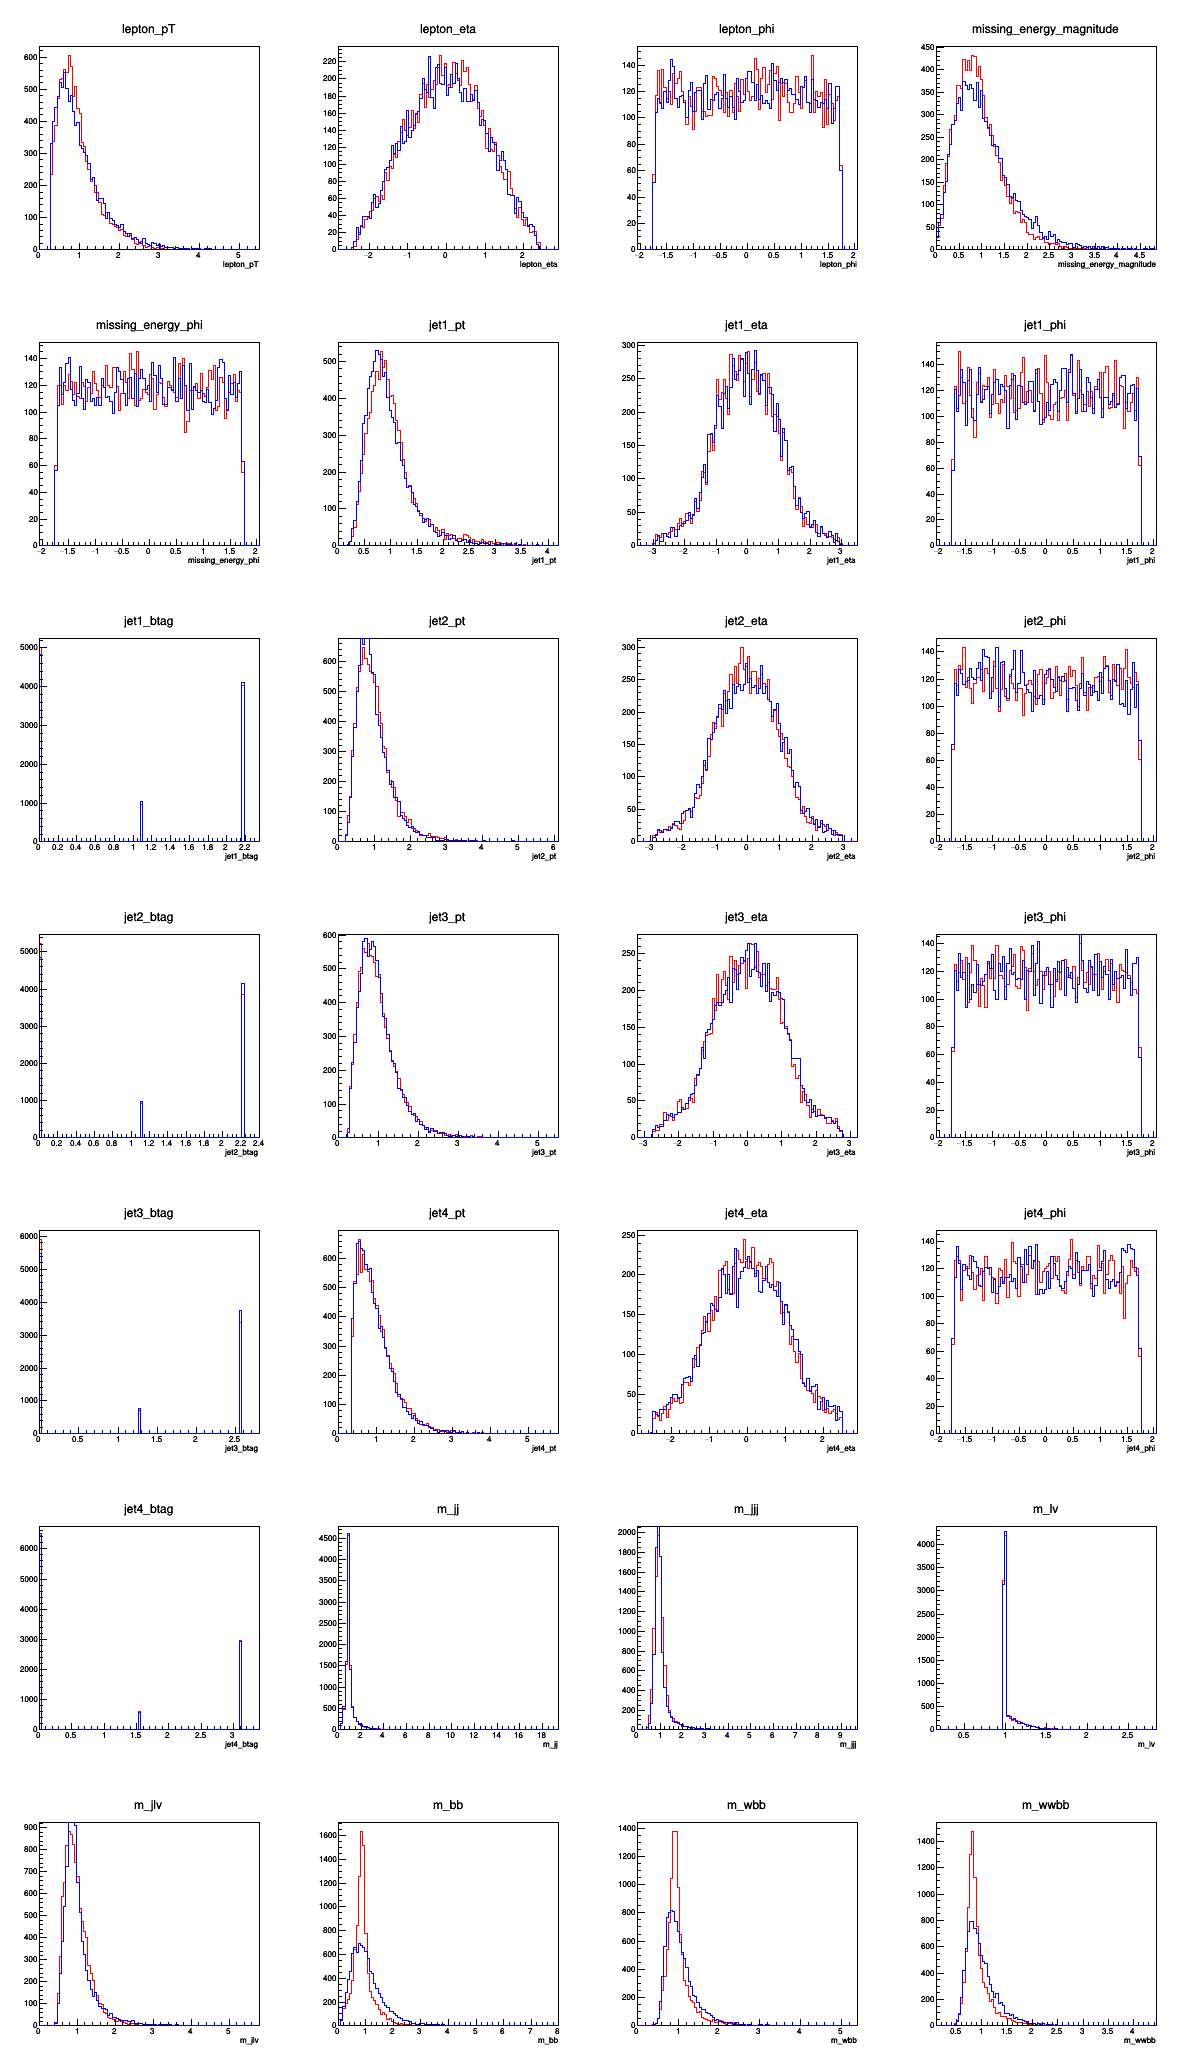

In [5]:
# Check the ROOT manual for more info on TCanvas and TTree::Draw
# e.g. https://root.cern.ch/doc/master/classTTree.html
cInput = ROOT.TCanvas("Input Variables", "", 1200, 2100)
cInput.Divide(4,7) # Dividing the canvas into 28
ROOT.gStyle.SetOptStat(0) # Removing display of statistics for each histogram

# Ensuring we use a different color for drawing the contents of the signal and background trees
sigTree.SetLineColor(ROOT.kRed)
bkgTree.SetLineColor(ROOT.kBlue)

# Looping over all the variables available in the TTree
for i,v in enumerate(sigTree.GetListOfBranches()):
    cInput.cd(i+1) # Selecting the sub-canvas (TPad) to draw into
    varName = v.GetName()
    sigTree.Draw(varName)
    bkgTree.Draw(varName, "", "same")
cInput.Draw()
cInput.Print(".pdf") # This saves a PDF file of the canvas

It is very important to look at the data beforehand and make sure it is well understood/modelled. In this simplified example already, we see that some variables do not provide a strong discriminating power.

Looking at the above, we see that some variables have some discrimiation potential: m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb. We will be using those in this tutorial.

Before adding the data to our loader, we might want to weight the events. This is needed for example when we simulate (using Monte Carlo event generators) many more events than what we expect to see in the data, which we need to scale in order to match the expectation in the data. Moreover, it is often needed to use many independent events to train machine learning algorithms.

We pick a few variables (present in the TTree) to use when running our machine learning.

We also have the possibility to select events based on some criterion (e.g. "m_jj>100") which we can speficy using a TCut object.

In [6]:
# Global event weights per tree: useful to adjust the event weight to match a given luminosity
sigWeight = 1.0
bkgWeight = 1.0

# Note: one can add any number of trees (e.g. multiple backgrounds)
loader.AddSignalTree    ( sigTree, sigWeight )
loader.AddBackgroundTree( bkgTree, bkgWeight )

# Adding variables (here corresponding to the branches of the TTree)
loader.AddVariable("m_jj")
loader.AddVariable("m_jjj")
loader.AddVariable("m_lv")
loader.AddVariable("m_jlv")
loader.AddVariable("m_bb")
loader.AddVariable("m_wbb")
loader.AddVariable("m_wwbb")


# Apply additional cuts on the signal and background samples (can be different)
sigCut = TCut("")   ## for example: TCut sigCut = "m_jj>100"
bkgCut = TCut("")   ## for example: TCut bkgCut = "m_jj>100"

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events


We will now prepare the *training* and *testing* trees to run the machine learning algorithms on.
We will use 7000 events from each signal and background trees for the traning sample; the remainder will be used fr the testing sample (as we didn't specify explicitly how many we wanted). The events will be chosen at random.

In [7]:
loader.PrepareTrainingAndTestTree( sigCut, bkgCut,
         "nTrain_Signal=7000:nTrain_Background=7000:SplitMode=Random:"
         "NormMode=NumEvents:!V" )

## Using machine learning algorithms with TMVA

We can now use various algorithms to classify events according to their signal or background characteristic. In order to use an algorithm within TMVA it has to be booked using the TMVA Factory's `BookMethod`.

We start with a Boosted Decison Tree (BDT). Details regarding the options can be found in the [TMVA User's Guide](https://root.cern.ch/download/doc/tmva/TMVAUsersGuide.pdf) under the BDT section.

In [8]:
factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT",
          "!V:NTrees=200:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:"
          "BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" )

<ROOT.TMVA::MethodBDT object ("BDT") at 0x7fa49e8ce600>

Factory                  : Booking method: BDT
                         : 
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 7000
                         : Signal     -- testing events             : 3000
                         : Signal     -- training and testing events: 10000
                         : Background -- training events            : 7000
                         : Background -- testing events             : 3000
                         : Background -- training and testing events: 10000
                         : 
DataSetInfo              : Correlation matrix (Signal):
                         : ----------------------------------------------------------------
  

The BookMethod function already provides some information regarding the dataset, such as the correlation matrices for the signal and background. These are important to look at to understand how the variables are correlated with each other.

We can now run the algorithms.

In [9]:
factory.TrainAllMethods()

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_jj' <---> Output : variable 'm_jj'
                         : Input : variable 'm_jjj' <---> Output : variable 'm_jjj'
                         : Input : variable 'm_lv' <---> Output : variable 'm_lv'
                         : Input : variable 'm_jlv' <---> Output : variable 'm_jlv'
                         : Input : variable 'm_bb' <---> Output : variable 'm_bb'
                         : Input : variable 'm_wbb' <---> Output : variable 'm_wbb'
                         : Input : variable 'm_wwbb' <---> Output : variable 'm_wwbb'
Factory                  : [dataset] : Create Transformation "D" with events from all classes.
                         : 
                         : Transformation, Variable selectio

0%, time left: unknown
7%, time left: 1 sec
13%, time left: 1 sec
19%, time left: 1 sec
25%, time left: 1 sec
32%, time left: 1 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec


In [10]:
factory.TestAllMethods()

Factory                  : Test all methods
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.0639 sec       


0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec


In [11]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT
                         : 
BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_BDT            : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     m_jj:     1.0204    0.63641   [    0.12185     17.681 ]
                         :    m_jjj:     1.0182    0.35745   [    0.45664     8.8785 ]
                         :     m_lv:     1.0482    0.16144   [    0.26740     3.7622 ]
                         :    m_jlv:     1.0020    0.39301   [    0.18584     6.3362 ]
                         :     m_bb:    0.97488    0.53678   [   0.095175     7.2843 ]
                         :    m_wbb:     1.0297    0.35792   [    0.40783     4.9710 ]
                         :   m_wwbb:   

The traninig is completed. The output it stored in the file we specified when creating the factory: `TMVA-Classification-Higgs.root`.

We can take a closer look at the performance of our algorithm by plotting the ROC (received operating characteristic) curve which shows how much background rejection our algorithm achieves for a given signal efficiency.

This metric is usually OK to compare algorithms but ultimately considerations such as the uncertainties on the background are necessary to assess whether it's more important to have a high signal efficiency or a high background rejection.

Info in <TCanvas::Print>: pdf file ./ROCCurve dataset class 0.pdf has been created


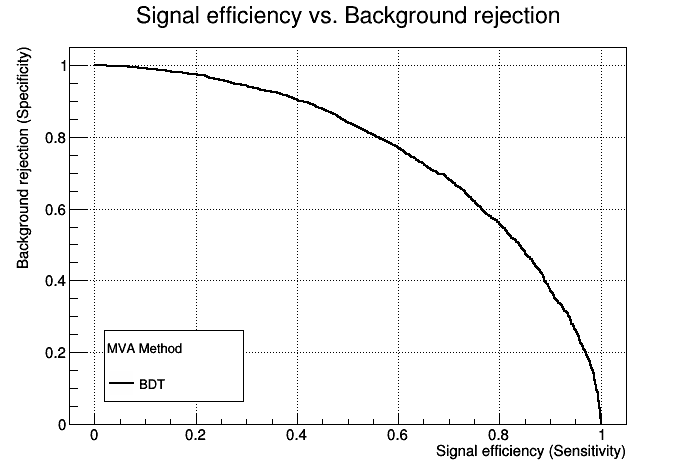

In [12]:
cROC = factory.GetROCCurve(loader)
cROC.Draw()
cROC.Print(".pdf") # This saves a PDF file of the canvas

In [13]:
# Taking a peek at the output file
ROOT.gDirectory.ls()

TDirectoryFile*		dataset	dataset
 TDirectoryFile*		InputVariables_Id	InputVariables_Id
  TDirectoryFile*		CorrelationPlots	CorrelationPlots
   KEY: TH2F	scat_m_jjj_vs_m_jj_Signal_Id;1	m_jjj versus m_jj (Signal)_Id
   KEY: TProfile	prof_m_jjj_vs_m_jj_Signal_Id;1	profile m_jjj versus m_jj (Signal)_Id
   KEY: TH2F	scat_m_jjj_vs_m_jj_Background_Id;1	m_jjj versus m_jj (Background)_Id
   KEY: TProfile	prof_m_jjj_vs_m_jj_Background_Id;1	profile m_jjj versus m_jj (Background)_Id
   KEY: TH2F	scat_m_lv_vs_m_jj_Signal_Id;1	m_lv versus m_jj (Signal)_Id
   KEY: TProfile	prof_m_lv_vs_m_jj_Signal_Id;1	profile m_lv versus m_jj (Signal)_Id
   KEY: TH2F	scat_m_lv_vs_m_jj_Background_Id;1	m_lv versus m_jj (Background)_Id
   KEY: TProfile	prof_m_lv_vs_m_jj_Background_Id;1	profile m_lv versus m_jj (Background)_Id
   KEY: TH2F	scat_m_jlv_vs_m_jj_Signal_Id;1	m_jlv versus m_jj (Signal)_Id
   KEY: TProfile	prof_m_jlv_vs_m_jj_Signal_Id;1	profile m_jlv versus m_jj (Signal)_Id
   KEY: TH2F	scat_m_jlv_vs_m_jj_Back

Info in <TCanvas::Print>: pdf file ./Correlation Matrices.pdf has been created


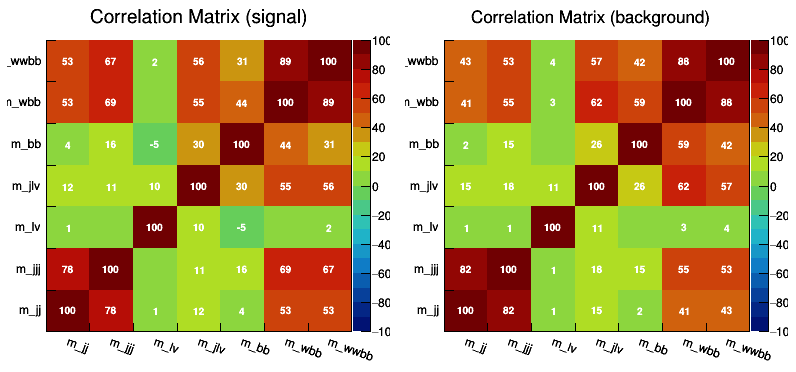

In [14]:
corrMatS = ROOT.gDirectory.Get("CorrelationMatrixS")
corrMatB = ROOT.gDirectory.Get("CorrelationMatrixB")

ROOT.gStyle.SetPalette(ROOT.kRainBow)
corrMat = ROOT.TCanvas("Correlation Matrices", "", 800, 400)
corrMat.Divide(2,1)
corrMat.cd(1)
corrMatS.Draw("colz text")
corrMat.cd(2)
corrMatB.Draw("colz text")
corrMat.Draw()
corrMat.Print(".pdf")

In [15]:
# Closing the file where we have the methods trained
outputFile.Close()
factory.Delete()

This tutorial introduced some of the basic concepts behind TMVA and BDTs. In the next tutorial, we will compare various algorithms with each other.

### Follow-up

One can adjust the various parameters of the BDT and see how things compare with each other. 

For example, one can adjust the number events to use in the training and testing sample, or the number of trees in the BDT to see the impact. Try to play with other parameters to get a feeling of how the algorithm works.

### Exploring the methods using the TMVAGui

TMVA comes with the TMVAGui, which helps understand how the algorithms behave. To run it, simply run
```
root -l -e 'TMVA::TMVAGui("TMVA-Classification-Higgs-BDT.root")'
```
from your terminal.